In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

### Binned Ratio (Modeled From Fig1_detect_nocifensive_behaviors Notebook)

In [2]:
### load predicted behaviors
behaviors = load_behaviors('../processed_dataset/behaviors_sni_combined.pkl')

In [6]:
### some params
# bin time 1 minute, change the last  number to 2 for 2 minute bins
num_min = 1
time_bin_size = 60*60*num_min
# take random file to compute total number of bins
n_bins = len(behaviors['A_Baseline_NoSNI']['control_mMORP-eYFP']['file0'])/time_bin_size

# Select groups
selected_group_1 = 'A_Baseline_NoSNI'
selected_group_2 = 'B_Baseline_SNI'
selected_group_3 = 'C_3WSNI_DCZ'
selected_group_4 = 'D_4WSNI_DCZ'

# Select Condition-- 'Control' or 'Experimental'
selected_condition_1 = 'exp_mMORP-hm4di'
selected_condition_2 = 'exp_mMORP-hm4di'
selected_condition_3 = 'exp_mMORP-hm4di'
selected_condition_4 = 'exp_mMORP-hm4di'

selected_groups = [selected_group_1, selected_group_2, selected_group_3, selected_group_4]
selected_conditions = [selected_condition_1, selected_condition_2, selected_condition_3, selected_condition_4]

# Adjust for selected_study
annotations = [f"{selected_group_1} {selected_condition_1} SNI-mMORp-DREADD", 
               f"{selected_group_2} {selected_condition_2} SNI-mMORp-DREADD", 
               f"{selected_group_3} {selected_condition_3} SNI-mMORp-DREADD"]

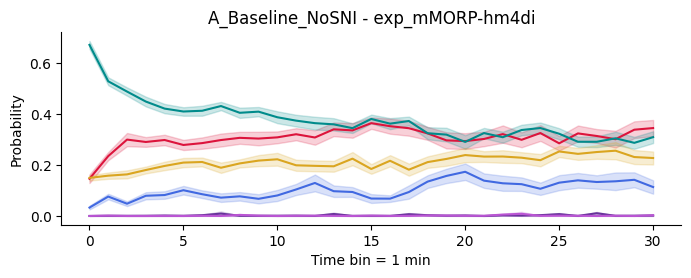

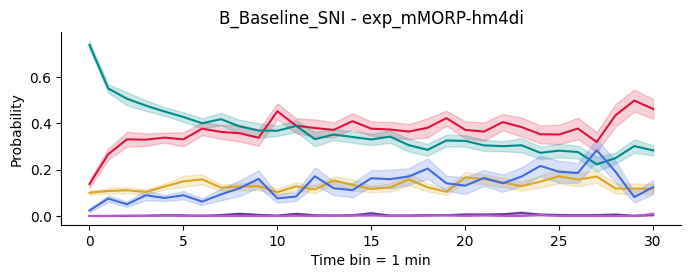

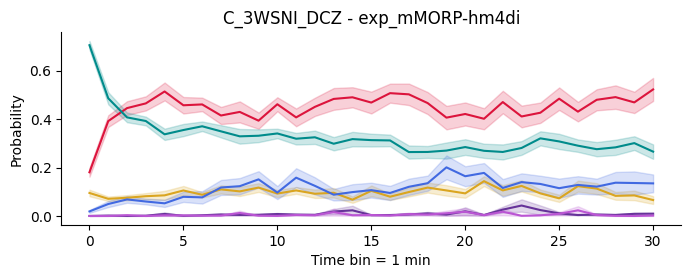

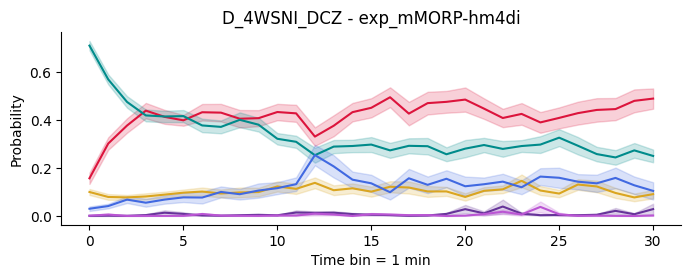

In [7]:
# Check if behaviors is None or empty
if behaviors is None or not behaviors:
    print("Error: Failed to load behaviors or empty dataset.")
else:
    # Assuming behavior_names and behavior_colors are defined elsewhere
    behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw_R']
    behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']

    # Define some params
    num_min = 1
    time_bin_size = 60 * 60 * num_min

    # Loop through selected_groups and selected_conditions
    for selected_group, selected_condition in zip(selected_groups, selected_conditions):
        # Check if selected_group and selected_condition exist in behaviors
        if selected_group in behaviors and selected_condition in behaviors[selected_group]:
            n_bins = len(behaviors[selected_group][selected_condition]['file0']) // time_bin_size

            fig, ax = plt.subplots(figsize=(8, 2.5))

            behavior_ratios_files = {key: np.nan for key in range(len(behaviors[selected_group][selected_condition]))}

            for f in range(len(behaviors[selected_group][selected_condition])):
                binned_behaviors = []
                for bin_n in range(int(n_bins)):
                    behavior_ratios = {key: 0 for key in range(len(behavior_names))}
                    values, counts = np.unique(behaviors[selected_group][selected_condition][f'file{f}'][time_bin_size * bin_n:time_bin_size * (bin_n + 1)], return_counts=True)
                    for i, value in enumerate(values):
                        behavior_ratios[value] = counts[i] / sum(counts)
                    binned_behaviors.append(behavior_ratios)
                behavior_ratios_files[f] = binned_behaviors

            for b in range(len(behavior_names)):
                y_files = []
                for f in range(len(behavior_ratios_files)):
                    y_files.append(np.hstack([behavior_ratios_files[f][bin][b] for bin in range(len(behavior_ratios_files[f]))]))
                y = np.mean(y_files, axis=0)
                x = np.arange(int(n_bins))
                y_sem = np.std(y_files, axis=0) / np.sqrt(len(behavior_ratios_files))

                ax.plot(x, y, color=behavior_colors[b], label=behavior_names[b])
                ax.fill_between(x, y - y_sem, y + y_sem, color=behavior_colors[b], alpha=0.2)

            ax.set_title(f'{selected_group} - {selected_condition}')
            ax.set_xlabel(f'Time bin = {num_min} min')
            ax.set_ylabel('Probability')
            ax.spines[['top', 'right']].set_visible(False)
            # ax.legend()
            
            # Save figure as SVG
            plt.savefig(f'../figures/{selected_group}_{selected_condition}.svg', format='svg')
            
            # Calculate mean and SEM for each behavior and save to CSV
            behavior_data = {'Time bin': np.arange(int(n_bins))}
            
            for b, behavior in enumerate(behavior_names):
                behavior_means = []
                behavior_sems = []
                for bin_idx in range(int(n_bins)):
                    behavior_values = [behavior_ratios_files[f][bin_idx][b] for f in range(len(behavior_ratios_files))]
                    behavior_mean = np.mean(behavior_values)
                    behavior_sem = np.std(behavior_values) / np.sqrt(len(behavior_ratios_files))
                    behavior_means.append(behavior_mean)
                    behavior_sems.append(behavior_sem)
                behavior_data[f'{behavior}_Mean'] = behavior_means
                behavior_data[f'{behavior}_SEM'] = behavior_sems

            behavior_df = pd.DataFrame(behavior_data)
            behavior_df.to_csv(f'../csvs/{selected_group}_{selected_condition}_mean_sem.csv', index=False)
            
            # Calculate mean and SEM
            # mean_data = np.mean(y_files, axis=0)
            # sem_data = np.std(y_files, axis=0) / np.sqrt(len(behavior_ratios_files))

            # Save mean and SEM as CSV
            # csv_data = np.column_stack((x, mean_data, sem_data))
            # np.savetxt(f'../csvs/sni_mMORpDREADD_control_mMORP-eYFP_MALE.csv', csv_data, delimiter=',', header='Time bin, Mean, SEM', comments='')

            plt.show()
        else:
            print(f"Error: Selected group '{selected_group}' or condition '{selected_condition}' not found in the dataset.")